In [2]:
import os
import torch
import torch.nn as nn
from datasets import get_ds
from cfg import get_cfg
from methods import get_method
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

from eval.get_data import get_data

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8"

In [4]:
def plot_tsne(feats, labels, fig, ax, label, perplexity, lr, num_poisons, keep):
    font = {'size': 12}
    plt.rc('font', **font)
    
    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, learning_rate=lr)
    y = labels.squeeze().cpu().numpy()
    
    x = feats.squeeze().cpu().numpy()
    x_tsne = tsne.fit_transform(x)
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    
    x_clean = x_tsne[:-num_poisons] 
    y_clean = y[:-num_poisons]
    for c, color in zip(keep, colors):
        ax.scatter(x_clean[y_clean==c][:, 0], x_clean[y_clean==c][:, 1], color=color)
        
    # patched data
    x_patched = x_tsne[-num_poisons:]
    y_patched = y[-num_poisons:]
    scat_p = ax.scatter(x_patched[:, 0], x_patched[:, 1], color='k', marker='^')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(label)

In [5]:
# 9 random classes and the target class is chosen. The list gives the label indices. Keep the target class at first index.
# 26 -> Rottweiler
# 44 -> ambulance
# 64 -> laptop
# 75 -> pirate ship
# 90 -> vacuum cleaner
keep = [26, 35, 39, 40, 42, 61, 68, 81, 85, 98]

In [6]:
def subset_classes(dataset, keep, num_classes=10):
    np.random.seed(1234)
    keep = set(keep)  
    file_list = []
    for row in dataset.file_list:
        im_path = row.split(" ")[0]
        im_class = int(row.split(" ")[1])
        if im_class in keep:
            file_list.append(im_path + " " + str(im_class) + "\n")
    dataset.file_list = file_list

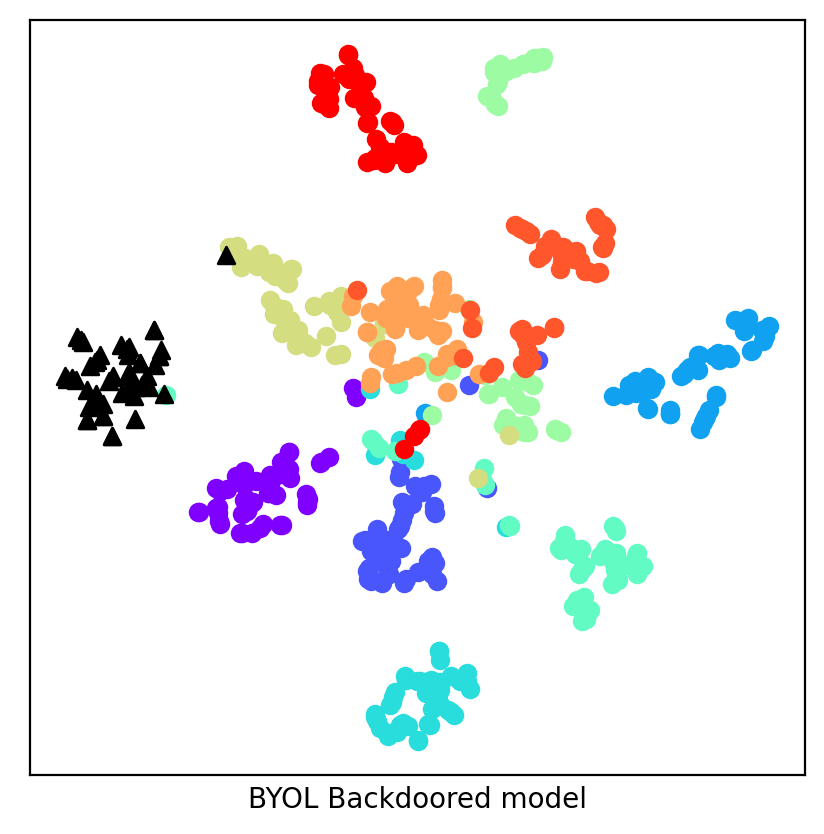

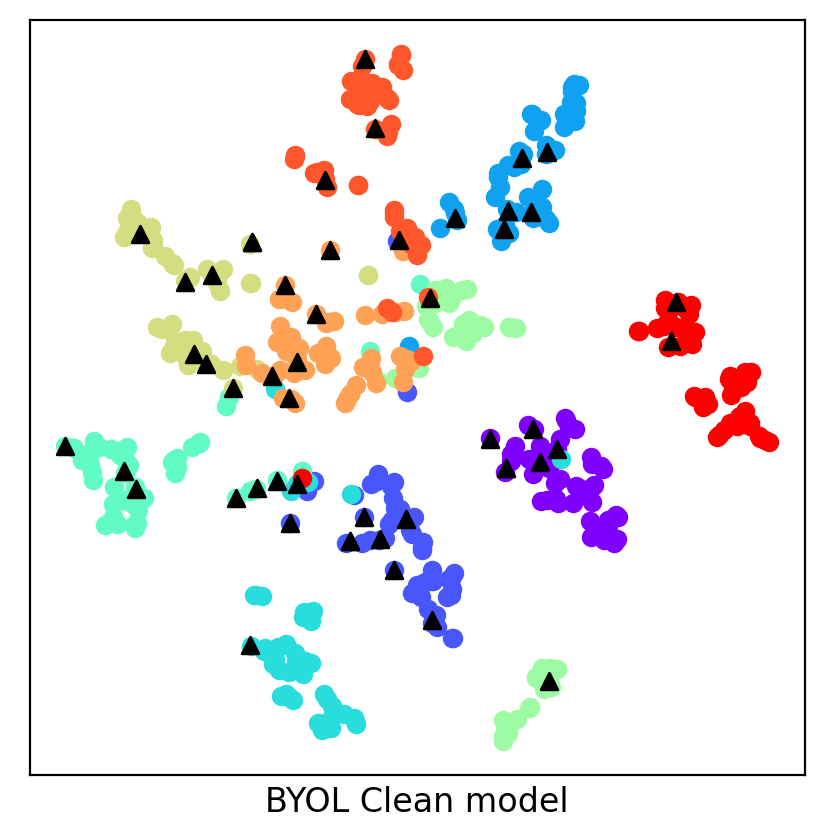

In [9]:
# hack to make argparse work in jupyter
import sys
sys.argv = ['']

cfg = get_cfg()
cfg.dataset = "imagenet"
cfg.arch = "resnet18"
cfg.emb = 128
cfg.method = 'byol'
cfg.val_file_path= "<PATH>"
cfg.val_poisoned_file_path= "<PATH>"
# checkpoint path
cfg.fname= "<PATH>"

topk=[1,]

model_full = get_method(cfg.method)(cfg)
model_full.cuda().eval()
if cfg.fname is None:
    print("evaluating random model")
else:
    model_full.load_state_dict(torch.load(cfg.fname))

ds = get_ds(cfg.dataset)(None, cfg, cfg.num_workers, bs_clf=5, bs_test=5)
device = "cpu" if cfg.clf == "lbfgs" else "cuda"
if cfg.eval_head:
    model = lambda x: model_full.head(model_full.model(x))
    out_size = cfg.emb
else:
    model = model_full.model
    out_size = model_full.out_size
    

subset_classes(ds.test.dataset, keep, num_classes=10)
subset_classes(ds.test_p.dataset, keep, num_classes=10)
x_test, y_test = get_data(model, ds.test, out_size, device)
x_test_p, y_test_p = get_data(model, ds.test_p, out_size, device)


NUM_POISONS=50
label = 'BYOL Backdoored model'
np.random.seed(123)
idx = np.random.randint(500, size=NUM_POISONS)
val_feats_stack = torch.cat((x_test, x_test_p[idx]))
val_labels_stack = torch.cat((y_test, y_test_p[idx]))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5), dpi=200)

for i, perplexity in enumerate([5]):
    for j, lr in enumerate([10]):
        plot_tsne(val_feats_stack, val_labels_stack, fig, ax, label, perplexity, lr, NUM_POISONS, keep)
        
# hack to make argparse work in jupyter
import sys
sys.argv = ['']

cfg = get_cfg()
cfg.dataset = "imagenet"
cfg.arch = "resnet18"
cfg.emb = 128
cfg.method = 'byol'
cfg.val_file_path= "<PATH>"
cfg.val_poisoned_file_path= "<PATH>"
# checkpoint path
cfg.fname= "<PATH>"

topk=[1,]

model_full = get_method(cfg.method)(cfg)
model_full.cuda().eval()
if cfg.fname is None:
    print("evaluating random model")
else:
    model_full.load_state_dict(torch.load(cfg.fname))

ds = get_ds(cfg.dataset)(None, cfg, cfg.num_workers, bs_clf=5, bs_test=5)
device = "cpu" if cfg.clf == "lbfgs" else "cuda"
if cfg.eval_head:
    model = lambda x: model_full.head(model_full.model(x))
    out_size = cfg.emb
else:
    model = model_full.model
    out_size = model_full.out_size
    

subset_classes(ds.test.dataset, keep, num_classes=10)
subset_classes(ds.test_p.dataset, keep, num_classes=10)
x_test, y_test = get_data(model, ds.test, out_size, device)
x_test_p, y_test_p = get_data(model, ds.test_p, out_size, device)

NUM_POISONS=50
label = 'BYOL Clean model'
np.random.seed(123)
idx = np.random.randint(500, size=NUM_POISONS)
val_feats_stack = torch.cat((x_test, x_test_p[idx]))
val_labels_stack = torch.cat((y_test, y_test_p[idx]))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5), dpi=200)

for i, perplexity in enumerate([5]):
    for j, lr in enumerate([10]):
        plot_tsne(val_feats_stack, val_labels_stack, fig, ax, label, perplexity, lr, NUM_POISONS, keep)